In [1]:
import pandas as pd
import numpy as np
import tqdm
import json
import networkx as nx
import matplotlib.pyplot as plt
import collections

### load data

In [2]:
cleaned_recipes = json.load(open("./../generated/high_score_repr_recipes.json"))
repr_per_id = json.load(open("./../generated/high_score_key_representative.json"))

In [3]:
cleaned_recipes[0]

['usda_id=11251',
 'black olife',
 'grape tomato',
 'usda_id=11215',
 'usda_id=11981',
 'purple onion',
 'usda_id=2075',
 'usda_id=16056',
 'usda_id=1019']

#### create graph

In [4]:
def name_ingredients(recipe) :
    
    named_ingredients = []
    
    for r in recipe :
        if r[:8] == "usda_id=" :
            named_ingredients.append(repr_per_id[r[8:]])
            
        else :
            named_ingredients.append(r)
            
    return named_ingredients
            

def ingredients_tuples(recipe) :
    
    tuples = []
    for ing1 in range(len(recipe) - 1) :
        for ing2 in range(ing1 + 1, len(recipe)) :
            if recipe[ing1] < recipe[ing2] :
                tuples.append((recipe[ing1], recipe[ing2]))
                
    return tuples

cleaned_name_recipes = [name_ingredients(r) for r in cleaned_recipes]
                
asso_counter = collections.Counter()
for recipe in tqdm.tqdm(cleaned_recipes) :
        asso_counter.update(ingredients_tuples(name_ingredients(recipe)))
            

100%|██████████| 96529/96529 [00:02<00:00, 42565.31it/s]


In [5]:
asso_counter.most_common()[271299]

(('buckwheat flour', 'salt & pepper'), 1)

In [6]:
ing_graph = nx.Graph()

for item in asso_counter.most_common() :
    ing_graph.add_edge(item[0][0],item[0][1],weight=item[1])

In [7]:
len(ing_graph.nodes)

4618

In [8]:
def nb_connections(from_ing, to_ing) :
    try :
        return ing_graph[from_ing][to_ing]['weight']
    except :
        return 0
    
def nb_asso(ing) :
    return sum([ing_graph[ing][c]['weight'] for c in ing_graph[ing]])
    
def nb_outgoing_edges(ing) :
    try :
        return ing_graph.degree[ing]
    except :
        return 0
    
def max_association(ing) :
    return max([ing_graph[ing][c]['weight'] for c in ing_graph[ing]])


#compute number of associations dictionnary
nb_assos = dict()
for ing in tqdm.tqdm(ing_graph.nodes) : 
    nb_assos[ing] = nb_asso(ing)


100%|██████████| 4618/4618 [00:00<00:00, 7217.51it/s]


#### define compatibility

In [9]:
def friendship(ing1, ing2) :
    ing1_likes_ing2 = (nb_connections(ing1, ing2) / nb_assos[ing1])
    ing2_likes_ing1 = (nb_connections(ing2, ing1) / nb_assos[ing2])
    friendship     =  max(ing1_likes_ing2, ing2_likes_ing1)
    return friendship


def recipe_compatibility(ingredient, recipe) :
    if ingredient in recipe : 
        return 0    
    else :         
        return sum([friendship(ingredient, ing) for ing in recipe]) / len(recipe)
    
#save compatibilities
compatibilities = dict()
for ing1 in tqdm.tqdm(ing_graph.nodes) :    
    per_ing = dict()
    
    for ing2 in ing_graph.nodes :
        per_ing[ing2] = friendship(ing1, ing2)
        
    compatibilities[ing1] = per_ing
        
json.dump(compatibilities, open("./../generated/high_score_ing_friendship.json", 'w'))

100%|██████████| 4618/4618 [01:00<00:00, 75.80it/s]


In [10]:
friendships = json.load(open("./../generated/high_score_ing_friendship.json"))

#### define replacement suggestion

In [11]:
def swap_candidates(replace_index, recipe, top=10) :
    
    all_ingredients = [ing for ing in ing_graph.nodes]
    to_replace = recipe[replace_index]
    recipe_rest = recipe.copy()
    recipe_rest.remove(to_replace)
    all_scores = []
    
    #compute friendship scores
    if (replace_index < 0) or (replace_index >= len(recipe)) :
        raise AttributeError("replace_index is out of bound !")
        
    else :
        for ing in all_ingredients :
            all_scores.append(recipe_compatibility(ing, recipe_rest))
            
    all_scores = np.array(all_scores)
    all_ingredients = np.array(all_ingredients)
    
    sorted_scores_index = np.argsort(-all_scores)[:top]    
    
    top_ingredients = all_ingredients[sorted_scores_index]
    top_scores = all_scores[sorted_scores_index][:top]
    
    return [c for c in zip(top_ingredients, top_scores)]

def bff(ing, nb=1) :
    index_sort = np.argsort(-np.array([ing_graph[ing][c]['weight'] for c in ing_graph[ing]]))
    return np.array([(c, ing_graph[ing][c]['weight']) for c in ing_graph[ing]][:nb])
            
    

In [12]:
bff("cumin", 10)

array([['salt', '2166'],
       ['cilantro', '1682'],
       ['onion', '1647'],
       ['chili powder', '1546'],
       ['oil', '1209'],
       ['tomato', '1204'],
       ['coriander', '1092'],
       ['black pepper', '1042'],
       ['garlic', '947'],
       ['pepper', '892']], dtype='<U12')

In [13]:
cleaned_name_recipes[0]

['romaine',
 'black olife',
 'grape tomato',
 'garlic',
 'pepper',
 'purple onion',
 'taco seasoning',
 'Chickpeas (garbanzo beans, bengal gram), mature seeds, raw',
 'feta']

In [14]:
swap_candidates(0, cleaned_name_recipes[0])

[('your favorite barbecue sauce', 0.0625),
 ('asian chile', 0.05357142857142857),
 ('salt', 0.044906005174799334),
 ('nonfat beef broth', 0.041666666666666664),
 ('kale - washed', 0.041666666666666664),
 ('oil', 0.03618470942257944),
 ('greek-style vinaigrette', 0.03409090909090909),
 ('onion', 0.031192727652172427),
 ('bottle italian salad dressing', 0.028846153846153848),
 ('bottle catalina salad dressing', 0.027777777777777776)]

We are not really accurate. This might be due to the 'classic' ingredients that prevent us from focusing on the more interesting associations. Let's study ingredients connectivity.

In [15]:
centrality = nx.algorithms.centrality.degree_centrality(ing_graph)
centrality_coeffs = [(ing, centrality[ing]) for ing in centrality]
centrality_coeffs.sort(key= lambda x : x[1], reverse=True)
centrality_coeffs[:10]

[('salt', 0.7680311890838206),
 ('onion', 0.6716482564435781),
 ('butter', 0.6584362139917695),
 ('water', 0.6432748538011696),
 ('oil', 0.6181503140567468),
 ('black pepper', 0.5791639592809184),
 ('egg', 0.5756985055230669),
 ('turbinado sugar', 0.5546891921160927),
 ('pepper', 0.5432098765432098),
 ('garlic', 0.5001082954299328)]

Indeed, the salt can be associated to pretty much every dish. let's visualize the centrality distribution

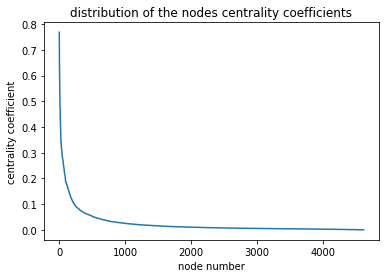

In [16]:
plt.title("distribution of the nodes centrality coefficients")
plt.xlabel("node number")
plt.ylabel("centrality coefficient")
plt.plot([c[1] for c in centrality_coeffs])

>The graph is highly unbalanced. There are some ingredients, a minority, that are connected to lots of other ingredients. On the other side, the rest of the ingredients is not connected to many ingredients. 
Now, we would like to know whether this phenomena is due to unbalanced dataset or if it is due to differents categories of ingredients, some being "general" enough to be assorted with any other, and some being more 'caracteristic'.
To  begin, we check the counts of all ingredients.

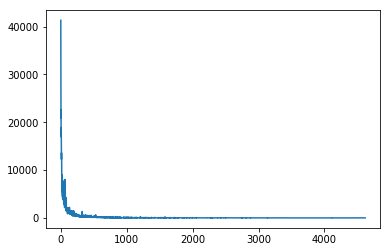

In [17]:
#count ingredients
ingredients_count = dict()
count_ings = collections.Counter()
for recipe in cleaned_name_recipes :
    count_ings.update(recipe)
    
for count in count_ings.most_common() :
    ingredients_count[count[0]] = count[1]

    
counts = []
centralities = []

for c in centrality_coeffs :
    counts.append(ingredients_count[c[0]])
    centralities.append(c[1])
    

    
plt.plot(counts)
plt.show()

### Introducing food groups